# This notebook aims to recalculate the similarity score by only comparing same-class TEs for each condition

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO, pairwise2
from itertools import combinations

/home/lucy/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [61]:
from scipy import stats

In [53]:
from matplotlib.patches import Patch

In [2]:
import os

## load all result df

In [15]:
squire_result_path = "./sequence_similarity_results/squire_result/"

In [ ]:
fnames = os.listdir(squire_result_path)

In [5]:
fnames = pd.Series( fnames)

In [6]:
fnames.sort_values( inplace = True )
fnames

1     resampledSquire_rand10_1_pairwise_identity.csv
14    resampledSquire_rand10_2_pairwise_identity.csv
0     resampledSquire_rand10_3_pairwise_identity.csv
3     resampledSquire_rand20_1_pairwise_identity.csv
15    resampledSquire_rand20_2_pairwise_identity.csv
12    resampledSquire_rand20_3_pairwise_identity.csv
7     resampledSquire_rand50_1_pairwise_identity.csv
8     resampledSquire_rand50_2_pairwise_identity.csv
9     resampledSquire_rand50_3_pairwise_identity.csv
6             squire_last50_df_pairwise_identity.csv
5              squire_top10_df_pairwise_identity.csv
4              squire_top20_df_pairwise_identity.csv
13             squire_top50_df_pairwise_identity.csv
11          squire_wt_top10_df_pairwise_identity.csv
2           squire_wt_top20_df_pairwise_identity.csv
10        squire_wt_top_all_df_pairwise_identity.csv
dtype: object

In [8]:
basenames1 = [ f'rand{i}_{j}' for i in [10, 20, 50] for j in [1,2,3] ]
#basenames1

In [10]:
basenames2 =  [ 'mut_last50'] + [f'mut_top{i}' for i in [10, 20, 50 ] ] 
basenames2 

['mut_last50', 'mut_top10', 'mut_top20', 'mut_top50']

In [11]:
basenames3 = [ f'wt_top{i}' for i in [10, 20, 33 ] ]

In [12]:
base_all = basenames1 + basenames2 + basenames3 
assert( len( base_all ) == len( fnames ) )

In [18]:
df_ls = []
for f in fnames:
    d = pd.read_csv( squire_result_path + f, header = 0, index_col = None )
    df_ls.append( d )

In [19]:
df_ls[0].head()

,ID1,ID2,PercentIdentity,Alignment_str
0,1553_RLTR4_MM-int,11552_B3A,29.423459,tggcaggggctgctatgggatcatctgcactggccttgcagaccca...
1,1553_RLTR4_MM-int,11163_B1_Mus1,26.242545,tggcaggggctgctatgggatcatctgcactggccttgcagaccca...
2,1553_RLTR4_MM-int,8570_RLTR4_MM-int,53.479125,tg-g-----ca---g-g---g--gc-tgctatgggatc-atct-g-...
3,1553_RLTR4_MM-int,10988_MT2B,31.212724,tggcaggggctgctatgggatcatctgcactggccttgcagaccca...
4,1553_RLTR4_MM-int,6820_RMER2,60.072595,tggcaggggc-tgct-atgggatcatctgcactggccttg-----c...


In [20]:
squire_indiv = pd.read_csv("/home/lucy/Dropbox/turner_organoid_bulk_RNA_local/Deseq_indiv_dTE_results.csv", header = 0, index_col = 0 )

In [21]:
squire_df_ind = squire_indiv.index.astype(str) + "_" + squire_indiv['repName']
squire_indiv['df_index_repName'] = squire_df_ind

In [23]:
squire_indiv2 = squire_indiv.set_index('df_index_repName')

## add class information to the dfs

In [24]:
repClass_dict = dict( zip( squire_indiv2.index, squire_indiv2['repClass'] ))
repFamily_dict = dict( zip( squire_indiv2.index, squire_indiv2['repFamily'] ))

In [25]:
def add_class_info( identity_df, repClass_dict ):
    identity_df['repClass1'] = [ repClass_dict[k] for k in identity_df['ID1'] ]
    identity_df['repClass2'] = [ repClass_dict[k] for k in identity_df['ID2'] ]
    return identity_df
    

In [26]:
for d in df_ls:
    d = add_class_info( d, repClass_dict )

In [27]:
df_ls[0].head()

,ID1,ID2,PercentIdentity,Alignment_str,repClass1,repClass2
0,1553_RLTR4_MM-int,11552_B3A,29.423459,tggcaggggctgctatgggatcatctgcactggccttgcagaccca...,LTR,SINE
1,1553_RLTR4_MM-int,11163_B1_Mus1,26.242545,tggcaggggctgctatgggatcatctgcactggccttgcagaccca...,LTR,SINE
2,1553_RLTR4_MM-int,8570_RLTR4_MM-int,53.479125,tg-g-----ca---g-g---g--gc-tgctatgggatc-atct-g-...,LTR,LTR
3,1553_RLTR4_MM-int,10988_MT2B,31.212724,tggcaggggctgctatgggatcatctgcactggccttgcagaccca...,LTR,LTR
4,1553_RLTR4_MM-int,6820_RMER2,60.072595,tggcaggggc-tgct-atgggatcatctgcactggccttg-----c...,LTR,LTR


## filter out different-class TEs

In [29]:
same_class_df_ls = []

for i,d in enumerate( df_ls):
    print( base_all[i] )
    print( f"Original df has {d.shape[0]} elements")
    
    d2 = d[ d['repClass1'] == d['repClass2'] ]
    same_class_df_ls.append( d2)

    print( f"Filtered df has { d2.shape[0]} elements")
    pct_left = d2.shape[0] / d.shape[0]
    print( f"{pct_left} left\n")

rand10_1
Original df has 45 elements
Filtered df has 17 elements
0.37777777777777777 left

rand10_2
Original df has 45 elements
Filtered df has 10 elements
0.2222222222222222 left

rand10_3
Original df has 45 elements
Filtered df has 16 elements
0.35555555555555557 left

rand20_1
Original df has 190 elements
Filtered df has 68 elements
0.35789473684210527 left

rand20_2
Original df has 190 elements
Filtered df has 61 elements
0.32105263157894737 left

rand20_3
Original df has 190 elements
Filtered df has 79 elements
0.41578947368421054 left

rand50_1
Original df has 1225 elements
Filtered df has 449 elements
0.36653061224489797 left

rand50_2
Original df has 1225 elements
Filtered df has 436 elements
0.35591836734693877 left

rand50_3
Original df has 1225 elements
Filtered df has 546 elements
0.44571428571428573 left

mut_last50
Original df has 1225 elements
Filtered df has 952 elements
0.7771428571428571 left

mut_top10
Original df has 45 elements
Filtered df has 36 elements
0.8 left


In [31]:
same_class_df_ls[0]

,ID1,ID2,PercentIdentity,Alignment_str,repClass1,repClass2
2,1553_RLTR4_MM-int,8570_RLTR4_MM-int,53.479125,tg-g-----ca---g-g---g--gc-tgctatgggatc-atct-g-...,LTR,LTR
3,1553_RLTR4_MM-int,10988_MT2B,31.212724,tggcaggggctgctatgggatcatctgcactggccttgcagaccca...,LTR,LTR
4,1553_RLTR4_MM-int,6820_RMER2,60.072595,tggcaggggc-tgct-atgggatcatctgcactggccttg-----c...,LTR,LTR
5,1553_RLTR4_MM-int,370_RLTR4_MM-int,47.045455,tggc-agg-----g-g-ctgctatgggat--cat-ctgcactg---...,LTR,LTR
7,1553_RLTR4_MM-int,6206_RLTR20C1_MM,34.393638,tggcaggggctgctatgggatcatctgcactggccttgcagaccca...,LTR,LTR
9,11552_B3A,11163_B1_Mus1,57.419355,g-agtctggag-ag-atgcct------c--g---gtggatgagagt...,SINE,SINE
24,8570_RLTR4_MM-int,10988_MT2B,38.563830,ttgtttttctttgtgtttgtt-gg-tgttg-gttatcttg---tcc...,LTR,LTR
25,8570_RLTR4_MM-int,6820_RMER2,50.816697,ttg---t------t-tttct---tt--g--tg---ttt--g-t--t...,LTR,LTR
26,8570_RLTR4_MM-int,370_RLTR4_MM-int,38.295455,--t------------tgt-ttt--t-ct--t-----------tg--...,LTR,LTR
28,8570_RLTR4_MM-int,6206_RLTR20C1_MM,42.021277,ttgtttttctttgtgtttgttggtgt-tggttatcttgtcctgtgt...,LTR,LTR


## make new summary df

### get related values

In [32]:
base_all

['rand10_1',
 'rand10_2',
 'rand10_3',
 'rand20_1',
 'rand20_2',
 'rand20_3',
 'rand50_1',
 'rand50_2',
 'rand50_3',
 'mut_last50',
 'mut_top10',
 'mut_top20',
 'mut_top50',
 'wt_top10',
 'wt_top20',
 'wt_top33']

In [33]:
num_elements = [ i for i in [10,20,50] for j in [1,2,3] ] # for the random controls
num_elements

[10, 10, 10, 20, 20, 20, 50, 50, 50]

In [34]:
# for the mutants
num_elements = num_elements + [ 50, 10, 20, 50 ]

# for the wt
num_elements = num_elements + [ 10, 20, 33 ] 

In [36]:
assert( len( num_elements) == len( same_class_df_ls ) )

In [105]:
len( set( df_ls[5]['ID2']).union(set( df_ls[5]['ID1'] )  ) )

20

In [97]:
len( same_class_df_ls[0]['ID1'].unique() )

7

In [110]:
summary_df = pd.DataFrame(index = 
                          ['avg_pctIdentity', 'std_pctIdentity', 'sum_pctIdentity',
                           'num_element_sampled' , 'num_combination_all',  'num_combination_left',
                           'adjusted_avg_pctIdentity'])

# TODO: modify here to quantity ( sum_score / supposed num element )

for i,df in enumerate( same_class_df_ls):
    # get data meta information
    f_id = base_all[i]
    num_e = num_elements[i]
    num_combination_all = df_ls[i].shape[0]
    num_combination_left = df.shape[0]
    
    #get avg and std score
    avg_score = df['PercentIdentity'].mean()
    std_score = df['PercentIdentity'].std()
    sum_score = df['PercentIdentity'].sum()
    adj_avg_score = sum_score / num_combination_all
    

    # add result to the result df
    summary_df[ f_id ] = [ avg_score, std_score, sum_score, num_e,  num_combination_all, num_combination_left,  adj_avg_score ]
    
    
    
    

In [111]:
summary_df

,rand10_1,rand10_2,rand10_3,rand20_1,rand20_2,rand20_3,rand50_1,rand50_2,rand50_3,mut_last50,mut_top10,mut_top20,mut_top50,wt_top10,wt_top20,wt_top33
avg_pctIdentity,41.044898,23.545173,38.993040,37.015965,45.155696,29.952781,37.117118,34.337222,35.169853,31.434792,32.527466,36.315880,34.631975,26.551235,35.150159,36.372366
std_pctIdentity,12.371912,16.773674,15.758340,20.442693,17.743509,18.269443,19.421103,19.727401,18.328902,21.797414,23.805879,27.612099,24.642663,19.383292,20.323129,20.309442
sum_pctIdentity,697.763273,235.451730,623.888634,2517.085638,2754.497475,2366.269666,16665.585974,14971.028763,19202.739661,29925.922066,1170.988783,5047.907301,34493.447156,451.370988,2495.661321,7783.686331
num_element_sampled,10.000000,10.000000,10.000000,20.000000,20.000000,20.000000,50.000000,50.000000,50.000000,50.000000,10.000000,20.000000,50.000000,10.000000,20.000000,33.000000
num_combination_all,45.000000,45.000000,45.000000,190.000000,190.000000,190.000000,1225.000000,1225.000000,1225.000000,1225.000000,45.000000,190.000000,1225.000000,45.000000,190.000000,528.000000
num_combination_left,17.000000,10.000000,16.000000,68.000000,61.000000,79.000000,449.000000,436.000000,546.000000,952.000000,36.000000,139.000000,996.000000,17.000000,71.000000,214.000000
adjusted_avg_pctIdentity,15.505851,5.232261,13.864192,13.247819,14.497355,12.454051,13.604560,12.221248,15.675706,24.429324,26.021973,26.567933,28.157916,10.030466,13.135060,14.741830


### format the summary df

In [112]:
conditions = [ 'control' for i in range( 9) ] + [ 'mutant_up' for i in range( 4)] + [ 'wt_up' for i in range(3 ) ]
len( conditions )

16

In [113]:
summary_df.shape

(7, 16)

In [114]:
summary_df = summary_df.T

In [115]:
summary_df['condition'] = conditions 

In [120]:
summary_df.head(2)

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,condition
rand10_1,41.044898,12.371912,697.763273,10.0,45.0,17.0,15.505851,control
rand10_2,23.545173,16.773674,235.451730,10.0,45.0,10.0,5.232261,control


In [118]:
summary_df['condition'] = pd.Categorical( summary_df['condition'], categories=['control' , 'wt_up' , 'mutant_up' ] )

In [121]:
summary_df.sort_values( by = ['num_element_sampled' ,'condition'], inplace= True )

In [122]:
summary_df.index

Index(['rand10_1', 'rand10_2', 'rand10_3', 'wt_top10', 'mut_top10', 'rand20_1',
       'rand20_2', 'rand20_3', 'wt_top20', 'mut_top20', 'wt_top33', 'rand50_1',
       'rand50_2', 'rand50_3', 'mut_last50', 'mut_top50'],
      dtype='object')

In [123]:
reordered_index = ['rand10_1', 'rand10_2', 'rand10_3', 'wt_top10', 'mut_top10', 'rand20_1',
       'rand20_2', 'rand20_3', 'wt_top20', 'mut_top20', 'rand50_1',
       'rand50_2', 'rand50_3', 'wt_top33', 'mut_last50', 'mut_top50']

In [126]:
summary_df = summary_df.loc[ reordered_index ]

In [140]:
summary_df.head()

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,condition
rand10_1,41.044898,12.371912,697.763273,10.0,45.0,17.0,15.505851,control
rand10_2,23.545173,16.773674,235.451730,10.0,45.0,10.0,5.232261,control
rand10_3,38.993040,15.758340,623.888634,10.0,45.0,16.0,13.864192,control
wt_top10,26.551235,19.383292,451.370988,10.0,45.0,17.0,10.030466,wt_up
mut_top10,32.527466,23.805879,1170.988783,10.0,45.0,36.0,26.021973,mutant_up


In [141]:
adjusted_std = summary_df['std_pctIdentity'] * (summary_df['num_combination_left'] / summary_df['num_combination_all']  )

In [142]:
summary_df['adj_std_pctIdentity'] = adjusted_std

## make the new bar plots

### compare number of element sampled and left after filtering

In [137]:
condition_colors = {
    'control': 'gray',
    'mutant_up': 'salmon',
    'wt_up':'cornflowerblue'
}

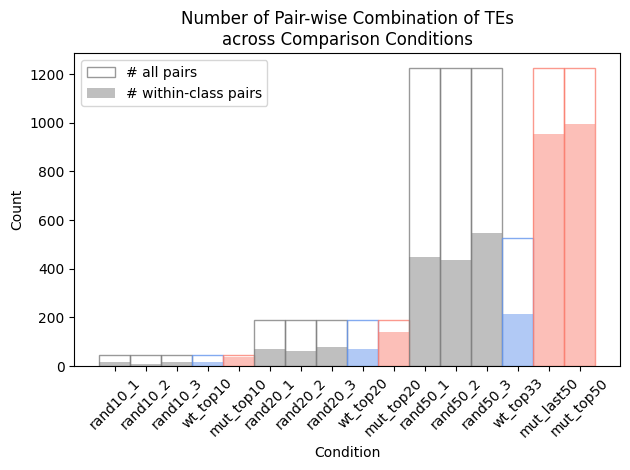

In [138]:
# Example data
x_pos = np.arange(len(summary_df.index))
heights1 = summary_df['num_combination_all']  # dataset 1
heights2 = summary_df['num_combination_left' ]   # dataset 2

all_pair_colors = [condition_colors[cond] for cond in summary_df['condition'] ]


bar_width = 1 # need to adjust

# Plot side-by-side histograms
plt.bar(x_pos , heights1, width=bar_width, label='# all pairs', alpha=0.8, edgecolor=all_pair_colors, facecolor='none',)
plt.bar(x_pos , heights2, width=bar_width, label='# within-class pairs', alpha=0.5, color =all_pair_colors)

# Add labels and legend
plt.xticks(x_pos, summary_df.index, rotation = 45)
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Number of Pair-wise Combination of TEs\nacross Comparison Conditions')
plt.legend()
plt.tight_layout()
plt.show()


### only avg similarity score

In [124]:
condition_colors = {
    'control': 'gray',
    'mutant_up': 'salmon',
    'wt_up':'cornflowerblue'
}

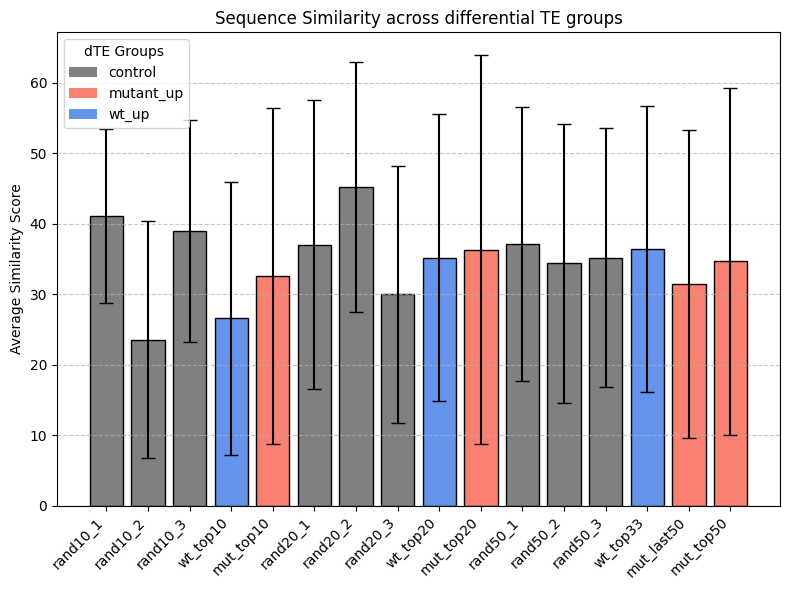

In [129]:
bar_colors = [condition_colors[cond] for cond in summary_df['condition'] ]

plt.figure(figsize=(8, 6))


plt.bar(summary_df.index, summary_df['avg_pctIdentity'] , yerr=summary_df['std_pctIdentity'], capsize=5, color=bar_colors, edgecolor='black')

plt.xticks(rotation=45, ha='right') 

legend_elements = [Patch(facecolor=color, label=cond) for cond, color in condition_colors.items()]
plt.legend(handles=legend_elements, title='dTE Groups ')


plt.ylabel('Average Similarity Score')
plt.title('Sequence Similarity across differential TE groups')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


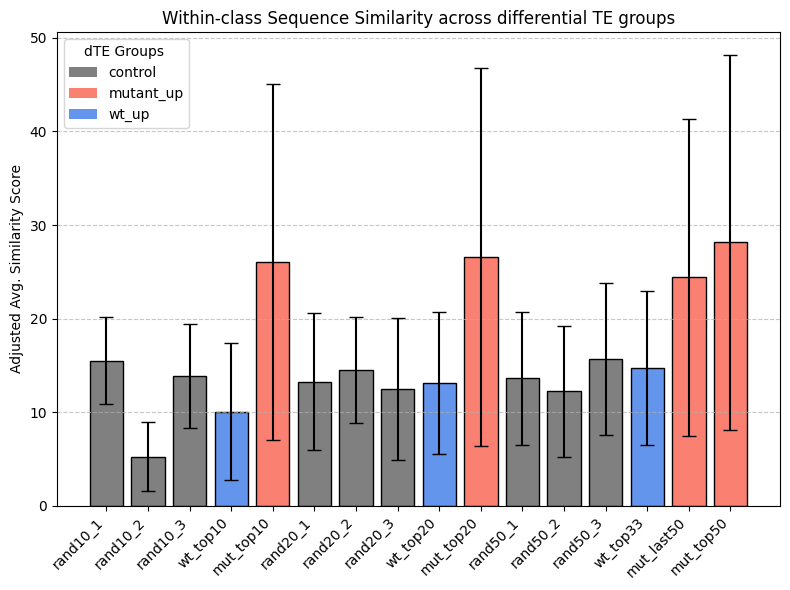

In [143]:
bar_colors = [condition_colors[cond] for cond in summary_df['condition'] ]

plt.figure(figsize=(8, 6))


plt.bar(summary_df.index, summary_df['adjusted_avg_pctIdentity'] , yerr=summary_df['adj_std_pctIdentity'], capsize=5, color=bar_colors, edgecolor='black')

plt.xticks(rotation=45, ha='right') 

legend_elements = [Patch(facecolor=color, label=cond) for cond, color in condition_colors.items()]
plt.legend(handles=legend_elements, title='dTE Groups ')

plt.ylabel('Adjusted Avg. Similarity Score')
plt.title('Within-class Sequence Similarity across differential TE groups')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


## summary of summary ( may not be reflective to real differences though)

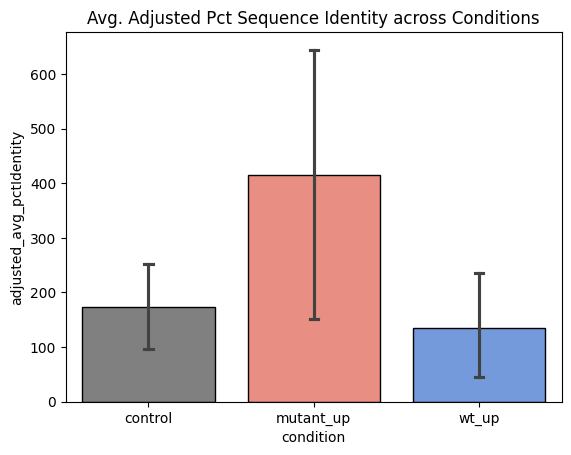

In [60]:
sns.barplot( summary_df, y ='adjusted_avg_pctIdentity' , x = 'condition' , hue= 'condition', palette= condition_colors, edgecolor = 'black', capsize = 0.05 )
plt.title( 'Avg. Adjusted Pct Sequence Identity across Conditions')
plt.show()

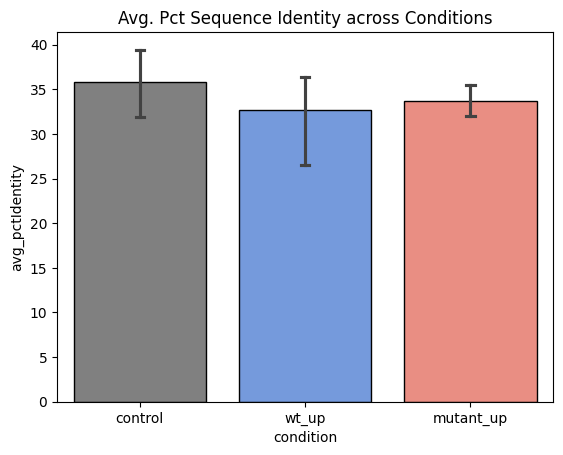

In [91]:
sns.barplot( summary_df, y ='avg_pctIdentity' , x = 'condition' , hue= 'condition', palette= condition_colors, edgecolor = 'black', capsize = 0.05 )
plt.title( 'Avg. Pct Sequence Identity across Conditions')
plt.show()

In [62]:
ctrl = summary_df['adjusted_avg_pctIdentity'][summary_df['condition'] == 'control']
mut = summary_df['adjusted_avg_pctIdentity'][summary_df['condition'] == 'mutant_up']
wt = summary_df['adjusted_avg_pctIdentity'][summary_df['condition'] == 'wt_up']

In [63]:
# Assuming equal variances (default)
t_mut_ctrl, p_mut_ctrl = stats.ttest_ind(list(mut), list( ctrl) )
t_wt_ctrl, p_wt_ctrl = stats.ttest_ind(list(wt), list( ctrl) )
t_mmut_wt, p_mut_wt = stats.ttest_ind(list(mut), list( wt) )

In [64]:
print( 'Mut vs control')
print( [t_mut_ctrl, p_mut_ctrl ] )

print( '\nWT vs control' )
print( [t_wt_ctrl, p_wt_ctrl ])

print( '\nMut vs WT' )
print( [t_mmut_wt, p_mut_wt ])

Mut vs control
[2.2167227323288476, 0.04864342607119224]

WT vs control
[-0.44934238259016424, 0.6627665327656052]

Mut vs WT
[1.6590349022026594, 0.1580047507077214]


In [93]:
ctrl0 = summary_df['avg_pctIdentity'][summary_df['condition'] == 'control']
mut0 = summary_df['avg_pctIdentity'][summary_df['condition'] == 'mutant_up']
wt0 = summary_df['avg_pctIdentity'][summary_df['condition'] == 'wt_up']

In [94]:
# Assuming equal variances (default)
t_mut_ctrl, p_mut_ctrl = stats.ttest_ind(list(mut0), list( ctrl0) )
t_wt_ctrl, p_wt_ctrl = stats.ttest_ind(list(wt0), list( ctrl0) )
t_mmut_wt, p_mut_wt = stats.ttest_ind(list(mut0), list( wt0) )

In [95]:
print( 'Mut vs control')
print( [t_mut_ctrl, p_mut_ctrl ] )

print( '\nWT vs control' )
print( [t_wt_ctrl, p_wt_ctrl ])

print( '\nMut vs WT' )
print( [t_mmut_wt, p_mut_wt ])

Mut vs control
[-0.6345261059316291, 0.5387103077583725]

WT vs control
[-0.767479381517707, 0.4605336537923542]

Mut vs WT
[0.35876917708338585, 0.7344194308076961]


## save data

In [148]:
summary_df.head()

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,condition,adj_std_pctIdentity
rand10_1,41.044898,12.371912,697.763273,10.0,45.0,17.0,15.505851,control,4.673833
rand10_2,23.545173,16.773674,235.451730,10.0,45.0,10.0,5.232261,control,3.727483
rand10_3,38.993040,15.758340,623.888634,10.0,45.0,16.0,13.864192,control,5.602965
wt_top10,26.551235,19.383292,451.370988,10.0,45.0,17.0,10.030466,wt_up,7.322577
mut_top10,32.527466,23.805879,1170.988783,10.0,45.0,36.0,26.021973,mutant_up,19.044703


In [149]:
logi = pd.read_csv("./OUTPUT_EXPLAIN.csv", header = 0, index_col= 0)

In [150]:
logi.columns

Index(['count_table_indiv.csv', 'count_table_subF.csv', 'mm39_rmsk_full.tsv',
       'Deseq_indiv_locus_results.csv', 'genoLoc_Deseq_indiv_locus_result.csv',
       'compare_dTE_overlap/', 'genoLoc_TCPS_Deseq_indiv_locus_result.csv',
       'TCPS_all_Deseq_indiv_locus.csv', 'resampled_TCPS_all_TE_indi.csv',
       'TCPS_seq_similarity_summary_df.csv',
       'squire_tjp2_mut_seq_similarity_summary_df.csv',
       'squire_tjp2_wt_seq_similarity_summary_df.csv',
       'squire_tjp2_total_seq_similarity_summary_df.csv',
       'mouse_human_combined_similarity_suammry_df.csv'],
      dtype='object')

In [152]:
logi['squire_tjp2_total_seq_similarity_summary_df.csv']

nb_created                                                   4d
nb_updated                                                  NaN
explain       summary df for sequence similarity scores for ...
Name: squire_tjp2_total_seq_similarity_summary_df.csv, dtype: object

In [151]:
logi['squire_tjp2_total_seq_similarity_summary_df.csv'].loc['explain']

'summary df for sequence similarity scores for all conditinos for the squire TE quantification of turner mouse organoids. Includes WT, KO and randomly selected control samples'

In [153]:
logi['squire_tjp2_total_seq_similarity_summary_df.csv'].loc['explain'] = 'summary df for sequence similarity scores for all conditinos for the squire TE quantification of turner mouse organoids. Includes WT, KO and randomly selected control samples. The control samples are from re-sampled pool of all TEs to match the dTE seq len distribution'

In [154]:
summary_df.to_csv("./squire_tjp2_total_seq_similarity_grouped_repClass_summary_df.csv", header = True, index = True )

In [155]:
logi['squire_tjp2_total_seq_similarity_grouped_repClass_summary_df.csv'] = ['8b' , 'NA' , 'summary df for seq similarity score for all conditions of turner mouse organoid data squire quantified. Including wt, mut and randomly selected sampled as control. This sum df only includes pair-wise comparison of TE from the same class'] 

In [156]:
logi.columns

Index(['count_table_indiv.csv', 'count_table_subF.csv', 'mm39_rmsk_full.tsv',
       'Deseq_indiv_locus_results.csv', 'genoLoc_Deseq_indiv_locus_result.csv',
       'compare_dTE_overlap/', 'genoLoc_TCPS_Deseq_indiv_locus_result.csv',
       'TCPS_all_Deseq_indiv_locus.csv', 'resampled_TCPS_all_TE_indi.csv',
       'TCPS_seq_similarity_summary_df.csv',
       'squire_tjp2_mut_seq_similarity_summary_df.csv',
       'squire_tjp2_wt_seq_similarity_summary_df.csv',
       'squire_tjp2_total_seq_similarity_summary_df.csv',
       'mouse_human_combined_similarity_suammry_df.csv',
       'squire_tjp2_total_seq_similarity_grouped_repClass_summary_df.csv'],
      dtype='object')

In [157]:
logi.to_csv("OUTPUT_EXPLAIN.csv", header = True, index = True )